In [ ]:
import pandas as pd
import numpy as np

import cv2
import ast
import math

from ast import literal_eval    #to convert columns into sepecific datatype
from skimage import io
import torch
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import imgaug as ia
import imgaug.augmenters as iaa

from torch import nn
from torch import optim
from torchvision.utils import make_grid
from torch.autograd import Variable
import sklearn.metrics as metri
from tqdm.auto import tqdm
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
import os

In [ ]:
! pip install kaggle

! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

! chmod 600 ~/.kaggle/kaggle.json

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
! kaggle datasets download -d pushpakbhoge/image-quality-detection

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python2.7/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python2.7/dist-packages/kaggle/api/kaggle_api_extended.py", line 146, in authenticate
    self.config_file, self.config_dir))
IOError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


In [ ]:
! unzip image-quality-detection.zip

In [ ]:
## Data preprocessing

dataset_path = "../input/image-quality-detection/"

df = pd.read_csv("data.csv")
data = df.copy()

## Converting str list back to list
data.output_array = data.output_array.apply(ast.literal_eval)

def arr_to_binary(arr):
    irrelevant_subs = 5
    if arr[irrelevant_subs] == 1:
        return 1
    else:
        return 0
    
data.output = data.output_array.apply(arr_to_binary)
data.drop(["task_id", "annot_id", "output_array"], axis=1, inplace=True)

data["image_name"] = "images/" + data["image_name"].astype("str")

## Dropping duplicates and resetting the index
data.drop_duplicates(subset='image_name',keep='first',inplace=True)
data.reset_index(drop=True,inplace=True)

## Splitting into train and test dataset
train, test = train_test_split(data,test_size=0.3,random_state=1)
train.reset_index(drop=True,inplace=True)
test.reset_index(drop=True,inplace=True)

train_x=train['image_name'].values
train_y=train['output'].values

test_x=test['image_name'].values
test_y=test['output'].values

In [ ]:
## Efficient net

net_params = {
        # 'efficientnet type': (width_coef, depth_coef, resolution, dropout_rate)
        'efficientnet-b0': (1.0, 1.0, 224, 0.2),
        'efficientnet-b1': (1.0, 1.1, 240, 0.2),
        'efficientnet-b2': (1.1, 1.2, 260, 0.45),
        'efficientnet-b3': (1.2, 1.4, 300, 0.3),
        'efficientnet-b4': (1.4, 1.8, 380, 0.4),
        'efficientnet-b5': (1.6, 2.2, 456, 0.4),
        'efficientnet-b6': (1.8, 2.6, 528, 0.5),
        'efficientnet-b7': (2.0, 3.1, 600, 0.5)
    }

class Swish(nn.Module):
    def __init__(self):
        super(Swish, self).__init__()

        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        return x * self.sigmoid(x)

def _RoundChannels(c, divisor=8, min_value=None):
    if min_value is None:
        min_value = divisor
    new_c = max(min_value, int(c + divisor / 2) // divisor * divisor)
    if new_c < 0.9 * c:
        new_c += divisor
    return new_c

def _RoundRepeats(r):
    return int(math.ceil(r))

def _DropPath(x, drop_prob, training):
    if drop_prob > 0 and training:
        keep_prob = 1 - drop_prob
        if x.is_cuda:
            mask = Variable(torch.cuda.FloatTensor(x.size(0), 1, 1, 1).bernoulli_(keep_prob))
        else:
            mask = Variable(torch.FloatTensor(x.size(0), 1, 1, 1).bernoulli_(keep_prob))
        x.div_(keep_prob)
        x.mul_(mask)

    return x

def _BatchNorm(channels, eps=1e-3, momentum=0.01):
    return nn.BatchNorm2d(channels, eps=eps, momentum=momentum)

def _Conv3x3Bn(in_channels, out_channels, stride):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, stride, 1, bias=False),
        _BatchNorm(out_channels),
        Swish()
    )

def _Conv1x1Bn(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 1, 1, 0, bias=False),
        _BatchNorm(out_channels),
        Swish()
    )

class SqueezeAndExcite(nn.Module):
    def __init__(self, channels, squeeze_channels, se_ratio):
        super(SqueezeAndExcite, self).__init__()

        squeeze_channels = squeeze_channels * se_ratio
        if not squeeze_channels.is_integer():
            raise ValueError('channels must be divisible by 1/ratio')

        squeeze_channels = int(squeeze_channels)
        self.se_reduce = nn.Conv2d(channels, squeeze_channels, 1, 1, 0, bias=True)
        self.non_linear1 = Swish()
        self.se_expand = nn.Conv2d(squeeze_channels, channels, 1, 1, 0, bias=True)
        self.non_linear2 = nn.Sigmoid()

    def forward(self, x):
        y = torch.mean(x, (2, 3), keepdim=True)
        y = self.non_linear1(self.se_reduce(y))
        y = self.non_linear2(self.se_expand(y))
        y = x * y

        return y

class MBConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, expand_ratio, se_ratio, drop_path_rate):
        super(MBConvBlock, self).__init__()

        expand = (expand_ratio != 1)
        expand_channels = in_channels * expand_ratio
        se = (se_ratio != 0.0)
        self.residual_connection = (stride == 1 and in_channels == out_channels)
        self.drop_path_rate = drop_path_rate

        conv = []

        if expand:
            # expansion phase
            pw_expansion = nn.Sequential(
                nn.Conv2d(in_channels, expand_channels, 1, 1, 0, bias=False),
                _BatchNorm(expand_channels),
                Swish()
            )
            conv.append(pw_expansion)

        # depthwise convolution phase
        dw = nn.Sequential(
            nn.Conv2d(
                expand_channels,
                expand_channels,
                kernel_size,
                stride,
                kernel_size//2,
                groups=expand_channels,
                bias=False
            ),
            _BatchNorm(expand_channels),
            Swish()
        )
        conv.append(dw)

        if se:
            # squeeze and excite
            squeeze_excite = SqueezeAndExcite(expand_channels, in_channels, se_ratio)
            conv.append(squeeze_excite)

        # projection phase
        pw_projection = nn.Sequential(
            nn.Conv2d(expand_channels, out_channels, 1, 1, 0, bias=False),
            _BatchNorm(out_channels)
        )
        conv.append(pw_projection)

        self.conv = nn.Sequential(*conv)

    def forward(self, x):
        if self.residual_connection:
            return x + _DropPath(self.conv(x), self.drop_path_rate, self.training)
        else:
            return self.conv(x)

class EfficientNet(nn.Module):
    config = [
        #(in_channels, out_channels, kernel_size, stride, expand_ratio, se_ratio, repeats)
        [32,  16,  3, 1, 1, 0.25, 1],
        [16,  24,  3, 2, 6, 0.25, 2],
        [24,  40,  5, 2, 6, 0.25, 2],
        [40,  80,  3, 2, 6, 0.25, 3],
        [80,  112, 5, 1, 6, 0.25, 3],
        [112, 192, 5, 2, 6, 0.25, 4],
        [192, 320, 3, 1, 6, 0.25, 1]
    ]

    def __init__(self, param, num_classes=1000, stem_channels=32, feature_size=1280, drop_connect_rate=0.2):
        super(EfficientNet, self).__init__()

        # scaling width
        width_coefficient = param[0]
        if width_coefficient != 1.0:
            stem_channels = _RoundChannels(stem_channels*width_coefficient)
            for conf in self.config:
                conf[0] = _RoundChannels(conf[0]*width_coefficient)
                conf[1] = _RoundChannels(conf[1]*width_coefficient)

        # scaling depth
        depth_coefficient = param[1]
        if depth_coefficient != 1.0:
            for conf in self.config:
                conf[6] = _RoundRepeats(conf[6]*depth_coefficient)

        # scaling resolution
        input_size = param[2]

        # stem convolution
        self.stem_conv = _Conv3x3Bn(3, stem_channels, 2)

        # total #blocks
        total_blocks = 0
        for conf in self.config:
            total_blocks += conf[6]

        # mobile inverted bottleneck
        blocks = []
        for in_channels, out_channels, kernel_size, stride, expand_ratio, se_ratio, repeats in self.config:
            # drop connect rate based on block index
            drop_rate = drop_connect_rate * (len(blocks) / total_blocks)
            blocks.append(MBConvBlock(in_channels, out_channels, kernel_size, stride, expand_ratio, se_ratio, drop_rate))
            for _ in range(repeats-1):
                drop_rate = drop_connect_rate * (len(blocks) / total_blocks)
                blocks.append(MBConvBlock(out_channels, out_channels, kernel_size, 1, expand_ratio, se_ratio, drop_rate))
        self.blocks = nn.Sequential(*blocks)

        # last several layers
        self.head_conv = _Conv1x1Bn(self.config[-1][1], feature_size)
        self.dropout = nn.Dropout(param[3])
        self.classifier = nn.Linear(feature_size, num_classes)

#         # Sigmoid Activation
#         self.sigmoid_active = torch.sigmoid() ## change to sigmoid

        self._initialize_weights()

    def forward(self, x):
        x = self.stem_conv(x)
        x = self.blocks(x)
        x = self.head_conv(x)
        x = torch.mean(x, (2, 3))
        x = self.dropout(x)
        x = self.classifier(x)
        x = torch.sigmoid(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2.0 / n))
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                n = m.weight.size(1)
                m.weight.data.normal_(0, 0.01)
                m.bias.data.zero_()

In [ ]:
model_name = 'efficientnet-b2'
num_classes = 1
learning_rate = 1e-1
weight_decay = 0
batch_size=8
save_frq=1
epoch_num = 15
initial_epoch = 32


base_dir="images/"
parameters = net_params[model_name]
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device='cpu'
pretrained = True

#os.mkdir('checkpoints2(no class weights)')
checkpoint_dir = os.path.join('checkpoints2(no class weights)', 'irrelevantImg(decay)_31.pth')

In [ ]:
class CustomDataset:
    def __init__(self,image_names,targets,augmentations=None):
        self.image_names=image_names
        self.targets=targets
        self.augmentations=augmentations
    
    def __len__(self):
        return len(self.image_names)
    
    def __getitem__(self,idx):
        
        image_name=self.image_names[idx]
        target=self.targets[idx]
        image=io.imread(self.image_names[idx])
        
        common_aug=iaa.Resize({'height':parameters[2],'width':parameters[2]})
        image=common_aug(image=image)
        
        if self.augmentations:
            if target==1:
                image=self.augmentations(image=image)
            #image = image[:3,:,:]

        image=image.transpose(2,0,1)            #channel,height,width for training
        image=image/255
        return {
            "image_name":image_name,
            "image":image,
            "target":target
        }
    

In [ ]:
## Augmentations

sometimes = lambda aug: iaa.Sometimes(0.5, aug)

train_augmentations = iaa.Sequential(
    [
        #
        # Apply the following augmenters to most images.
        #
       # iaa.Fliplr(0.5), # horizontally flip 50% of all images
        #iaa.Flipud(0.2), # vertically flip 20% of all images
        
          #resize acc to model parameters

        # crop some of the images by 0-10% of their height/width
        sometimes(iaa.Crop(percent=(0, 0.1))),

        # Apply affine transformations to some of the images
        # - scale to 80-120% of image height/width (each axis independently)
        # - translate by -20 to +20 relative to height/width (per axis)
        # - rotate by -45 to +45 degrees
        # - shear by -16 to +16 degrees
        # - order: use nearest neighbour or bilinear interpolation (fast)
        # - mode: use any available mode to fill newly created pixels
        #         see API or scikit-image for which modes are available
        # - cval: if the mode is constant, then use a random brightness
        #         for the newly created pixels (e.g. sometimes black,
        #         sometimes white)
        sometimes(iaa.Affine(
            scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
            translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
            rotate=(-20, 20),
            shear=(-16, 16),
            order=[0, 1],
            cval=(0, 255),
            mode=ia.ALL
        ))

        
    ],
    # do all of the above augmentations in random order
    random_order=True
)

## Datasets 
train_dataset=CustomDataset(train_x,train_y,augmentations=train_augmentations)
test_dataset=CustomDataset(test_x,test_y)

## Dataloaders
train_loader=torch.utils.data.DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
test_loader=torch.utils.data.DataLoader(test_dataset,batch_size=batch_size,shuffle=False)

In [ ]:
class Logging():
    def __init__(self, out_dir):
        self.out_dir = out_dir
        self.template = {}
        
        # create template
        fields = ['epoch', 'loss', 'accuracy']
        for field in fields:
            self.template[field] = []
        
        # create headers if file not already present
        if not os.path.exists(self.out_dir):
            with open(self.out_dir, 'a') as file:
                file.write(','.join(self.template.keys())+'\n')
        
    def log(self, epoch, loss, acc):
        with open(self.out_dir, 'a') as file:
            file.write(','.join([epoch, loss, acc])+'\n')
            
            
def get_accuracy(y_pred, y_true):
    equality = (y_pred==y_true)
    
    #print(y_pred)
    #print(y_true)
    acc = equality.type(torch.FloatTensor).mean()
    return acc

In [ ]:
## Defining the model
net = EfficientNet(parameters, num_classes=num_classes)
net.to(device)

criterion = nn.BCELoss()
optimizer = optim.Adam(net.parameters(), weight_decay=weight_decay, lr=learning_rate)

# if pretrained==True:
#     loaded_state = torch.load(checkpoint_dir)
#     net.load_state_dict(loaded_state['InterferenceModel'])
#     optimizer.load_state_dict(loaded_state['InterferenceOpt'])
#     print("weights loaded")

In [ ]:
os.mkdir('log2(no class weights)')

train_logger = Logging(os.path.join('log2(no class weights)','train(decay)_log.csv'))


running_loss = 0
ite_num = 0
true_accu = []
pred_accu = []
n = 0

net.train()

for epoch in range(initial_epoch, initial_epoch+epoch_num):
    # put model in training mode
    print(f'starting epoch {epoch}')
    
    for row in tqdm(train_loader):
        inputs, labels = row['image'], row['target']
        
        # fetch data
        inputs = inputs.to(device).float()
        #print(inputs)
        labels = labels.to(device)
        #print(inputs.shape,labels[0])
        labels=labels.unsqueeze(1)
        labels=labels.float()

        # y zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        probabilities = net.forward(inputs)
        #print(probabilities)
        #print(labels)
        loss = criterion(probabilities, labels)
        loss.backward()
        optimizer.step()
        
        # count images
        n += len(labels)
        
        # accumulate loss
        running_loss += loss.data.item()
        
        # calculate and accumulate accuracy
       # probabilities = torch.exp(cls_logits)
        predictions = (probabilities>0.5).float()
        #print(predictions)
        true_accu.append(labels)
        pred_accu.append(predictions)
        
    # calculate train accuracy
    true_accu = torch.cat(true_accu)
    pred_accu = torch.cat(pred_accu)
    
    t=true_accu
    p=pred_accu
    
    train_acc = get_accuracy(pred_accu, true_accu)
    
    running_loss = running_loss/n
    
    #print(train_acc,running_loss)
    
    # save model
    
    if (epoch)%save_frq==0:
        torch.save({
                    "irrelevantImgModel":net.state_dict(),
                    "irrelevantImgOpt":optimizer.state_dict()
                    }, os.path.join('checkpoints2(no class weights)', "irrelevantImg(decay)_{0}.pth".format(epoch)))
        print(f"model is saved at step {epoch}")

    
    print(f"epoch : {epoch}")
    print(f"train loss - {running_loss} train accuracy - {train_acc}")
   # print(f"val loss - {val_loss} val accuracy - {val_acc}")
    
    # log into the csv files
    train_logger.log(str(epoch), 
                    str(float(running_loss)), 
                    str(float(train_acc)))


    # reset mini batch accumulators
    running_loss = 0.0
    running_tar_loss = 0.0
    true_accu = []
    pred_accu = []
    n = 0

starting epoch 32



model is saved at step 32
epoch : 32
train loss - 0.783421187992082 train accuracy - 0.9365736842155457
starting epoch 33



model is saved at step 33
epoch : 33
train loss - 0.7861130902793568 train accuracy - 0.9367678761482239
starting epoch 34



model is saved at step 34
epoch : 34
train loss - 0.7869725346176588 train accuracy - 0.9367678761482239
starting epoch 35



model is saved at step 35
epoch : 35
train loss - 0.7881576276567713 train accuracy - 0.9367678761482239
starting epoch 36



model is saved at step 36
epoch : 36
train loss - 0.7893926111149345 train accuracy - 0.9367678761482239
starting epoch 37



model is saved at step 37
epoch : 37
train loss - 0.8014431052991514 train accuracy - 0.9356675744056702
starting epoch 38



model is saved at step 38
epoch : 38
train loss - 0.7904019157336095 train accuracy - 0.9367678761482239
starting epoch 39



model is saved at step 39
epoch : 39
train loss - 0.7904019157336095 train accuracy - 0.9367678761482239
starting epoch 40



model is saved at step 40
epoch : 40
train loss - 0.7904019157336095 train accuracy - 0.9367678761482239
starting epoch 41



model is saved at step 41
epoch : 41
train loss - 0.7904019157336095 train accuracy - 0.9367678761482239
starting epoch 42



model is saved at step 42
epoch : 42
train loss - 0.7904019157336095 train accuracy - 0.9367678761482239
starting epoch 43



model is saved at step 43
epoch : 43
train loss - 0.7904019157336095 train accuracy - 0.9367678761482239
starting epoch 44



model is saved at step 44
epoch : 44
train loss - 0.7904019157336095 train accuracy - 0.9367678761482239
starting epoch 45



model is saved at step 45
epoch : 45
train loss - 0.7917502644409077 train accuracy - 0.9367678761482239
starting epoch 46



model is saved at step 46
epoch : 46
train loss - 0.7904019157336095 train accuracy - 0.9367678761482239


In [ ]:
## Function defination for tests

def get_correct_and_wrong_images(img_lst, y_true, y_pred, class_idx, probs):
    correct_indices = ((y_pred == class_idx) & (y_true == class_idx)).tolist()
    incorrect_indics = ((y_pred!= class_idx) & (y_true == class_idx)).tolist()
    
    correct_imgs = [img_lst[i] for i in range(len(correct_indices)) if correct_indices[i][0]]
    incorrect_imgs = [img_lst[i] for i in range(len(incorrect_indics)) if incorrect_indics[i][0]]
    
    incorrectly_classified_as = [y_pred[i] for i in range(len(incorrect_indics)) if incorrect_indics[i][0]]
    incorrectly_classified_probs = [probs[i] for i in range(len(incorrect_indics)) if incorrect_indics[i][0]]
    
    return correct_imgs, incorrect_imgs, incorrectly_classified_as, incorrectly_classified_probs

def visualize_from_list(img_lst, label_list, img_row, img_col, clss_idx):
    images_to_visualize = img_row*img_col
    
    img_iter = iter(img_lst)
    label_iter = iter(label_list)

    fig, ax = plt.subplots(img_row,img_col, figsize=(img_row*4,img_col*3))
    plt.subplots_adjust(hspace=0.5)
    
    count = 1
    for i in range(img_row):
        for j in range(img_col):
            try:
                image_name = next(img_iter)
                label = next(label_iter)
            except:
                continue
            image=io.imread(base_dir+image_name)
            ax[i][j].imshow(image)
            ax[i][j].title.set_text(f'{count} '+ str(label))
            count+=1

In [ ]:
# Evaluation 
net.eval()

def get_evaluation_report(df, loader):
    probs = []
    image_names = []
    true_idxs = []
    pred_idxs = []
    entities_n = 0

    for row in tqdm(loader):
        # Load data
        
        image_name=row['image_name']
        inputs, labels = row['image'], row['target']
        
        # fetch data
        inputs = inputs.to(device).float()
        #print(inputs)
        labels = labels.to(device)
        #print(inputs.shape,labels[0])
        labels=labels.unsqueeze(1)
        labels=labels.float()

        with torch.no_grad():
            probabilities = net.forward(inputs)

        predictions = (probabilities>0.5).float()
        #print(predictions)
        true_idxs.append(labels)
        pred_idxs.append(predictions)
        
        #print(pred_idxs)

        # accumulate loss and accuracy
        image_names+=(image_name)

        probs.append(probabilities)

        # get number of entities and steps
        entities_n += len(labels)

    # concatenate all data
    probs = torch.cat(probs).cpu().numpy()
    true_idxs = torch.cat(true_idxs).cpu().numpy()
    print(true_idxs.shape)
    pred_idxs = torch.cat(pred_idxs).cpu().numpy()
    print(pred_idxs.shape)
    
    # get accuracy
    accuracy = metri.accuracy_score(true_idxs, pred_idxs)
    print(f"overall accuracy {accuracy}")

    # Get f1 accuracy
    f1_score = metri.f1_score(true_idxs, pred_idxs)
    print(f"overall f1_score {f1_score}")
    
    print(classification_report(true_idxs,pred_idxs))
    
    
    # Get per class accuracies
    incorrect_images_0 = {}
    incorrect_images_1={}

    print()
    
    correct_imgs, incorrect_imgs, incrrct_pred, probs_ = get_correct_and_wrong_images(image_names, true_idxs, 
                                                                    pred_idxs, 0, probs)
        
    incorrect_images_0=[incorrect_imgs, incrrct_pred, probs_]
    
    
    correct_imgs, incorrect_imgs, incrrct_pred, probs_ = get_correct_and_wrong_images(image_names, true_idxs, 
                                                                    pred_idxs, 1, probs)

    incorrect_images_1=[incorrect_imgs, incrrct_pred, probs_]


    confus_mat = metri.confusion_matrix(true_idxs, pred_idxs)

    fig, ax = plt.subplots(figsize=(8,6))
    sns.heatmap(confus_mat, annot=True, ax=ax)
    print()
    return incorrect_images_0,incorrect_images_1
 


(6622, 1)
(6622, 1)
overall accuracy 0.9335548172757475
overall f1_score 0.0
              precision    recall  f1-score   support

         0.0       0.93      1.00      0.97      6182
         1.0       0.00      0.00      0.00       440

    accuracy                           0.93      6622
   macro avg       0.47      0.50      0.48      6622
weighted avg       0.87      0.93      0.90      6622





/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


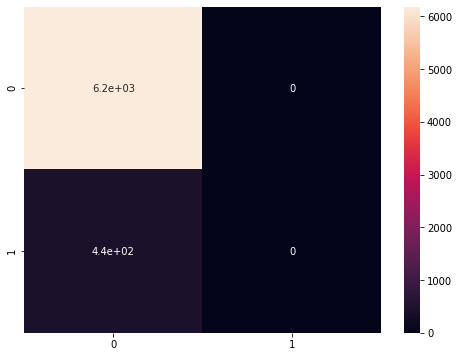

In [ ]:
incorrect_images_0,incorrect_images_1=get_evaluation_report(test,test_loader)


(977, 1)
(977, 1)
overall accuracy 0.0
overall f1_score 0.0
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       0.0
         1.0       0.00      0.00      0.00     977.0

    accuracy                           0.00     977.0
   macro avg       0.00      0.00      0.00     977.0
weighted avg       0.00      0.00      0.00     977.0





/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


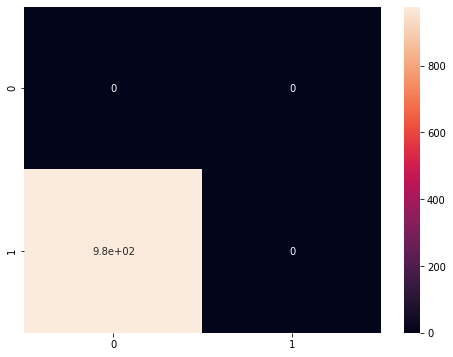

In [ ]:
## testing on labels of ones 

ones = train[train['output'] == 1]
ones.reset_index(drop=True,inplace=True)
testone_dataset=CustomDataset(ones["image_name"], ones["output"])
testone_loader=torch.utils.data.DataLoader(testone_dataset, batch_size=batch_size, shuffle=False)

iprobabilitiest_images_0,incorrect_images_1=get_evaluation_report(ones, testone_loader)

In [ ]:
var = test[test['output'] == 1]
var


(15451, 1)
(15451, 1)
overall accuracy 0.9367678467413112
overall f1_score 0.0
              precision    recall  f1-score   support

         0.0       0.94      1.00      0.97     14474
         1.0       0.00      0.00      0.00       977

    accuracy                           0.94     15451
   macro avg       0.47      0.50      0.48     15451
weighted avg       0.88      0.94      0.91     15451




/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


([[], [], []],
 [['images/93b74af6-d655-11eb-8248-0242ac15000220210626-080740.jpg',
   'images/58422eea-c47c-11eb-8f78-0242ac15000220210603-145950.jpg',
   'images/ee82c400-823c-11eb-9c6c-0242ac15000220210311-073937.jpg',
   'images/6df9be7a-c2cd-11eb-aa4b-0242ac15000220210601-113513.jpg',
   'images/4110d638-d7df-11eb-93c6-0242ac15000220210628-070543.jpg',
   'images/91f4ef3c-bedd-11eb-b923-0242ac15000220210527-112041.jpg',
   'images/41d550ec-c698-11eb-b602-0242ac15000220210606-072440.jpg',
   'images/9eb1fcc0-d7fa-11eb-ad1a-0242ac15000220210628-102136.jpg',
   'images/edd133a0-be39-11eb-a5df-0242ac15000220210526-154917.jpg',
   'images/eff56c14-c140-11eb-aa4b-0242ac15000220210530-121701.jpg',
   'images/aab6c094-bf92-11eb-b923-0242ac15000220210528-085701.jpg',
   'images/daad5134-d64c-11eb-93c6-0242ac15000220210626-070513.jpg',
   'images/b131f1ba-beb5-11eb-ace7-0242ac15000220210527-063513.jpg',
   'images/d5a30596-c448-11eb-8f78-0242ac15000220210603-085106.jpg',
   'images/733eca9e

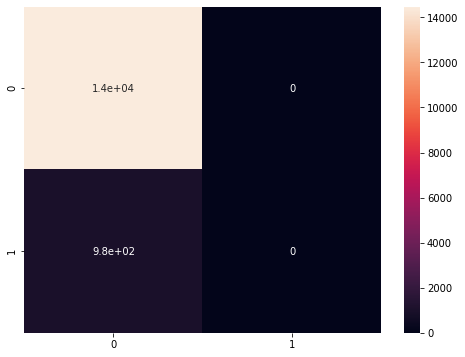

In [ ]:
get_evaluation_report(train,train_loader)